In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

In [2]:
vocabulary_size = 10000 # my unique words
sequence_length = 20 # hyperparameter - we take 20 words 

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocabulary_size)

/Users/iskriyanavasileva/opt/anaconda3/envs/dsr/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/iskriyanavasileva/opt/anaconda3/envs/dsr/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
#print(x_train)

In [4]:
#print(y_train)

2. Preprocessing

padding - making everything the same length, fills the code with 0s if it is not long enough; cuts something if it is not long enough

We defined length above by sequence_length = 20

vocabulary_size & sequence_length - define how fast the neural network will be

In [5]:
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=sequence_length)
x_test = preprocessing.sequence.pad_sequences(x_train, maxlen=sequence_length)

In [6]:
print(x_train.shape)
print(x_train[0])

(25000, 20)
[  65   16   38 1334   88   12   16  283    5   16 4472  113  103   32
   15   16 5345   19  178   32]


3. Train - validate split

Shuffle the data before the split 

Make sure to take also the y-s

In [7]:
split_index = int(0.8 * len(x_train))
imdb_train = tf.data.Dataset.from_tensor_slices(
    (x_train[:split_index], y_train[:split_index])

).cache()

imdb_validate = tf.data.Dataset.from_tensor_slices(
    (x_train[split_index:], y_train[split_index:])

).cache()


imdb_test = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)
).cache()

In [8]:
random_review, random_label = list(imdb_train.shuffle(10000).take(1))[0]
print(random_review)
print(random_review.shape)
print(random_label)

tf.Tensor(
[1188   14    9   89   24    8   97    6  325   20   81   49 2301    5
   28   49 3114   11  129 2220], shape=(20,), dtype=int32)
(20,)
tf.Tensor(0, shape=(), dtype=int64)


In [9]:
embedding_size = 8

model = models.Sequential()
# embedding is a mapping table - we take the 20 integers = indexes from a sample (see random_review)
# and take a look at the embedding table to see what is the corresponding vector
# embedding layer is the only one where we can use big integers (no standardisation)
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()


model.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=["accuracy"]

)

model.fit(
    imdb_train.shuffle(10000).batch(32), # it shuffles before the beginning of every epoch
    epochs=8,
    validation_data=imdb_validate.batch(32)
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
625/625 [==============================] - 1s 1ms/step - loss: 0.6687 - accuracy: 0.6089 - val_loss: 0.6072 - val_accuracy: 0.6962
Epoch 2/8
625/625 [==============================] - 1s 1ms/step - loss: 0.5209 - accuracy: 0.7645 - val_loss: 0.5169 - val_accuracy: 0.7368
Epoch 3/8
625/625 [==============================] - 1s 1ms/step - loss: 0.4319 - accuracy: 0.8116 -

In [10]:
history = model.fit(
    imdb_train.shuffle(10000).batch(32),
    epochs=8,
    validation_data=imdb_validate.batch(32) # I don't shuffle, because you do not change anything on the visualisation data
)

Epoch 1/8
625/625 [==============================] - 1s 1ms/step - loss: 0.2152 - accuracy: 0.9305 - val_loss: 0.5475 - val_accuracy: 0.7472
Epoch 2/8
625/625 [==============================] - 1s 1ms/step - loss: 0.1920 - accuracy: 0.9403 - val_loss: 0.5611 - val_accuracy: 0.7480
Epoch 3/8
625/625 [==============================] - 1s 1ms/step - loss: 0.1705 - accuracy: 0.9508 - val_loss: 0.5796 - val_accuracy: 0.7414
Epoch 4/8
625/625 [==============================] - 1s 1ms/step - loss: 0.1512 - accuracy: 0.9599 - val_loss: 0.5998 - val_accuracy: 0.7392
Epoch 5/8
625/625 [==============================] - 1s 1ms/step - loss: 0.1337 - accuracy: 0.9671 - val_loss: 0.6188 - val_accuracy: 0.7374
Epoch 6/8
625/625 [==============================] - 1s 1ms/step - loss: 0.1180 - accuracy: 0.9730 - val_loss: 0.6387 - val_accuracy: 0.7328
Epoch 7/8
625/625 [==============================] - 1s 1ms/step - loss: 0.1040 - accuracy: 0.9789 - val_loss: 0.6626 - val_accuracy: 0.7310
Epoch 8/8
625

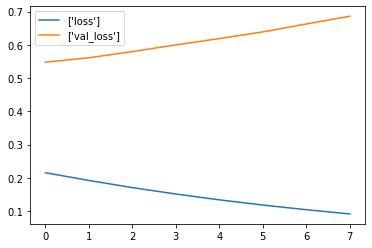

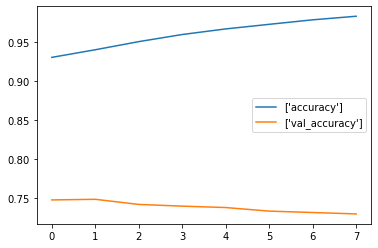

In [11]:
plt.plot(history.history["loss"], label=['loss'])
plt.plot(history.history["val_loss"], label=['val_loss'])
plt.legend()
plt.show()
plt.close()


plt.plot(history.history["accuracy"], label=['accuracy'])
plt.plot(history.history["val_accuracy"], label=['val_accuracy'])
plt.legend()
plt.show()
plt.close()

In [12]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

--2020-08-04 16:09:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-04 16:09:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-04 16:09:15--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
!y

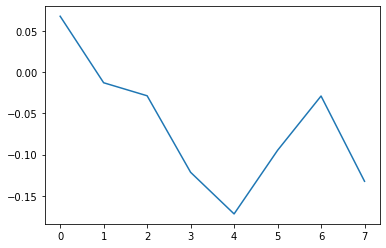

In [15]:
#model.layers[0].get_weights()[0].shape # embedding layer
plt.plot(model.layers[0].get_weights()[0][0])

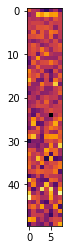

In [16]:
plt.imshow(model.layers[0].get_weights()[0][:50,:], cmap="inferno") #bright - high values

In [19]:
word_index = imdb.get_word_index() # only for this data set; small number - appears often, big number - appears seldom
# the numbers are shifted by 3, because a couple of tokens were introduced in between
# in the previous tensorflow_datasets the encoder took care of this
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3 #?

In [22]:
def get_embedding_of_word(word):
    assert word in word_index
    index = word_index[word]
    embedding = model.layers[0].get_weights()[0][index]
    
    return embedding

get_embedding_of_word("king")

array([ 0.17887421,  0.02570605, -0.14146467, -0.19228539,  0.09304307,
       -0.13187136,  0.02721258, -0.02947923], dtype=float32)

In [33]:
from scipy.spatial import distance

distance.cosine(get_embedding_of_word("king"),get_embedding_of_word("queen")) # similarity

1.5872103571891785

In [24]:
distance.cosine(get_embedding_of_word("king"),get_embedding_of_word("slave"))

0.45496904850006104

In [31]:
distance.cosine(get_embedding_of_word("king"),get_embedding_of_word("bottle"))

0.6192905902862549

In [40]:
distance.euclidean(get_embedding_of_word("king"),get_embedding_of_word("bottle"))

0.43252938985824585

Synchronise our vocabulary with the Glove one

Result: the look-up table for embedding with our indices from IMDB, BUT the vectors from Glove

In [41]:
embedding_size = 100
embedding_index = {}

f = open( "glove.6B.100d.txt")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embedding_index[word] = coefs
    
word_index = imdb.get_word_index()

max_words = 10000

embedding_matrix = np.zeros((vocabulary_size, embedding_size)) # 100, because you are bound by Glove

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if i < vocabulary_size - 3 and embedding_vector is not None:
        embedding_matrix[i + 3] = embedding_vector
        
print(embedding_matrix.shape)

(10000, 100)


In [44]:
model = models.Sequential()
model.add(layers.Embedding(
    vocabulary_size, 
    embedding_size, 
    input_length=sequence_length
))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))

model.layers[0].set_weights([embedding_matrix]) # !!!! important !!!! 
model.layers[0].trainable = False 

model.summary()

model.compile(
    optimizer="rmsprop", 
    loss="binary_crossentropy",
    metrics=["accuracy"])

history = model.fit(
    imdb_train.shuffle(10000).batch(32),
    epochs=10,
    validation_data=imdb_validate.batch(32)
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 100)           1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2001      
Total params: 1,002,001
Trainable params: 2,001
Non-trainable params: 1,000,000
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 1ms/step - loss: 0.6526 - accuracy: 0.6159 - val_loss: 0.6488 - val_accuracy: 0.6244
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5936 - accuracy: 0.6819 - val_loss: 0.6137 - val_accuracy: 0.6586
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5761 - acc

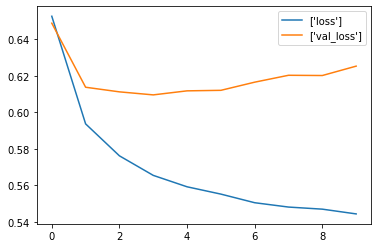

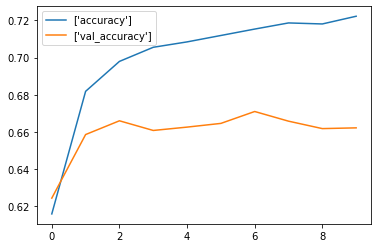

In [46]:
plt.plot(history.history["loss"], label=['loss'])
plt.plot(history.history["val_loss"], label=['val_loss'])
plt.legend()
plt.show()
plt.close()


plt.plot(history.history["accuracy"], label=['accuracy'])
plt.plot(history.history["val_accuracy"], label=['val_accuracy'])
plt.legend()
plt.show()
plt.close()